In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from IPython.display import display as dsp

## Mebourne Housing Prices

__The Data__

This data represents houses sold in Melbourne, Australia between the dates off January 4th, 2016 to December 1st, 2018. We want to train a model to predict the housing prices given a set of features. We also want to understand what features have the greatest effect (ruling out ensemble models, which would result in a 'black box').

__Ideas__

The dataset included coordinates for each house sold, which could be an interesting clustering project, but since every house is already associated with a neighborhood (whch tend to be spacially contiguous) we will include the coordinates within our model.

In [24]:
raw = pd.read_csv('data/Melbourne_housing_FULL.csv')
raw_less = pd.read_csv('data/MELBOURNE_HOUSE_PRICES_LESS.csv')

raw.dropna(inplace = True)
raw.reset_index(inplace = True)

raw_less.dropna()
raw_less.reset_index(inplace = True)

dsp(raw.tail())
dsp(raw_less.tail())

,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
8882,34847,Wollert,27 Birchmore Rd,3,h,500000.0,PI,Ray,24/02/2018,25.5,...,2.0,2.0,383.0,118.0,2016.0,Whittlesea City Council,-37.61940,145.03951,Northern Metropolitan,2940.0
8883,34849,Wollert,35 Kingscote Wy,3,h,570000.0,SP,RW,24/02/2018,25.5,...,2.0,2.0,404.0,158.0,2012.0,Whittlesea City Council,-37.61031,145.03393,Northern Metropolitan,2940.0
8884,34853,Yarraville,29A Murray St,2,h,888000.0,SP,Sweeney,24/02/2018,6.3,...,2.0,1.0,98.0,104.0,2018.0,Maribyrnong City Council,-37.81551,144.88826,Western Metropolitan,6543.0
8885,34854,Yarraville,147A Severn St,2,t,705000.0,S,Jas,24/02/2018,6.3,...,1.0,2.0,220.0,120.0,2000.0,Maribyrnong City Council,-37.82286,144.87856,Western Metropolitan,6543.0
8886,34856,Yarraville,3 Tarrengower St,2,h,1020000.0,PI,RW,24/02/2018,6.3,...,1.0,0.0,250.0,103.0,1930.0,Maribyrnong City Council,-37.81810,144.89351,Western Metropolitan,6543.0


,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
63018,63018,Roxburgh Park,3 Carr Pl,3,h,566000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63019,63019,Roxburgh Park,9 Parker Ct,3,h,500000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63020,63020,Roxburgh Park,5 Parkinson Wy,3,h,545000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63021,63021,Thomastown,3/1 Travers St,3,u,NaN,PI,Barry,31/03/2018,3074,Northern Metropolitan,7955,15.3,Whittlesea City Council
63022,63022,Williams Landing,1 Diadem Wy,4,h,NaN,SP,Aussie,31/03/2018,3027,Western Metropolitan,1999,17.6,Wyndham City Council


In [25]:
#Lets see exactly what we have to work with
print(raw.columns)

print('Number of Regions: {}'.format(len(raw['Regionname'].unique())))
print('Number of Counsil Areas: {}'.format(len(raw['CouncilArea'].unique())))
print('Number of Post Codes: {}'.format(len(raw['Postcode'].unique())))

Index(['index', 'Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method',
       'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom',
       'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea',
       'Lattitude', 'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')
Number of Regions: 8
Number of Counsil Areas: 33
Number of Post Codes: 194


__Building Our Features__

What do we want? We have two types of features: those that are intrinsic to the house (bedrooms, bathrooms), and those intrinsic to the location (distance, region). We will turn the region names into binary features (either the house is a part of a given region or not). I suspect we will see a lot of intercorrelation between features.

In [26]:
regions = raw.Regionname.unique()

#Outcome, features
data = raw[['Rooms', 'Distance', 'Lattitude','Longtitude', 'Bedroom2', 'Bathroom', 'Car', 'BuildingArea', 'Price']]

Y = data['Price']
X = data[['Rooms', 'Distance', 'Lattitude','Longtitude', 'Bedroom2', 'Bathroom', 'Car', 'BuildingArea']]


#Binary Features
for region in regions:
    data[str(region)] = np.where(raw['Regionname'] == region, 1, 0)
    X[str(region)] = np.where(raw['Regionname'] == region, 1, 0)
    
print(X.columns)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Index(['Rooms', 'Distance', 'Lattitude', 'Longtitude', 'Bedroom2', 'Bathroom',
       'Car', 'BuildingArea', 'Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Northern Victoria', 'Eastern Victoria',
       'Western Victoria'],
      dtype='object')


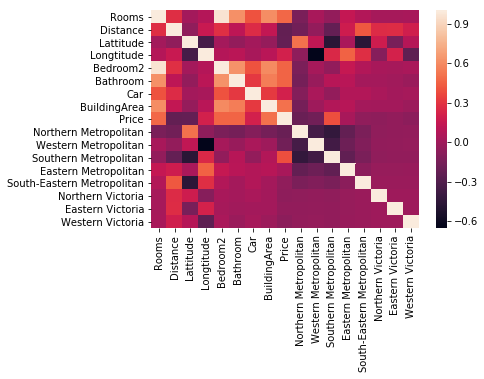

In [27]:
#Feature Validation
sns.heatmap(data.corr())

#Distance, Lattitude and Longitude do nothing but correlate to everything but price
data.drop(columns = ['Distance', 'Lattitude','Longtitude'], inplace = True)

__Feature Validation__

As we can see, there is an especially strong correlation between the intrinsic properties of the house (the number of bedrooms, bathrooms ect.). This is prime territory for principal component analysis.

In [28]:
#Principal Component Analysis
pca = PCA(n_components = 3)

#Colinear features
colin_feat_scaled = preprocessing.scale(X[['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom','Car']])

#Fit PCA function
pca.fit(colin_feat_scaled)

print('Percent variation explained by each component:\n{}'.format(
    np.round(pca.explained_variance_ratio_ * 100, decimals = 1)))

Percent variation explained by each component:
[64.7 15.4 10.3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


__PCA__

As we can see, the vast majority of the variance can be explained with only the first feature intrinsic to the property.

Now we need to perform dimensionality reduction to create composite features.

In [29]:
#Reduce features
feat_reduced = pca.fit_transform(colin_feat_scaled)

#Check Dimensions
print(colin_feat_scaled.shape)
print(feat_reduced.shape)
print(data.shape)
print(feat_reduced.T[0].shape)

#Add features to data
#for i in range(feat_reduced.shape[1]):
#    data['houseProperty{}'.format(i)] = feat_reduced.T[i]
data['houseAmenityRating'] = feat_reduced.T[0]

#Create features and outcomes
data.drop(columns = ['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom','Car'], inplace = True)
X = data.drop(columns = ['Price'])
Y = data['Price']

(8887, 5)
(8887, 3)
(8887, 14)
(8887,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/alexander/.local/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


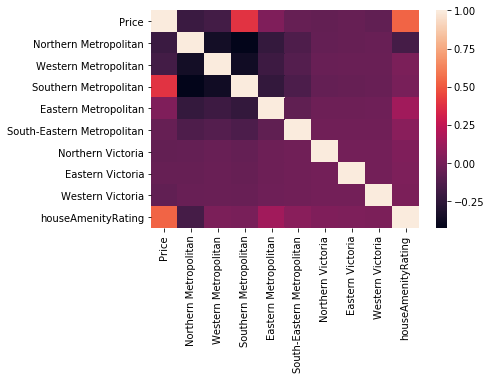

In [30]:
sns.heatmap(data.corr())

In [31]:
mvr = linear_model.LinearRegression()
cross_val_score(mvr, X, Y, cv = 5)

array([0.50333539, 0.45320193, 0.41398683, 0.3739592 , 0.39593474])

__Multivariate Regression__

Well, that didn't work at all! Lets look at a different approach.